Luis Adolfo Martínez 
**22000352** 

Objetivo: Teniendo un datase de precios de habitaciones de datos de Airbnb se busca crear un modelo para la prediccion de precios

In [2]:
import numpy as np
import pandas as pd

In [3]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.1 MB/s 
     |████████████████████████████████| 16.7 MB 382 kB/s 
     |████████████████████████████████| 6.3 MB 48.5 MB/s 


In [4]:
import matplotlib.pyplot as plt
import plotly as plotly
import seaborn as sns
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from folium import plugins

# Modelo de regresión lineal
from sklearn.linear_model import LinearRegression
# Preprocesamiento
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split
# Métricas de evaluación
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [5]:
# Gráficas de plotly
import plotly.offline as py 
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode, plot
from plotly import tools
init_notebook_mode(connected=True)


In [44]:
%matplotlib inline  

In [6]:
import os.path
from os import path

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
direccion = "/content/drive/MyDrive/TextMining/Archivos/MLP"
os.chdir(direccion)

In [9]:
# Cargamos los datos
dataset = pd.read_csv('AB_NYC_2019.csv')


In [10]:
dataset.head(10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
6,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,2017-10-05,0.40,1,0
7,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220
8,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,2017-07-21,0.99,1,0
9,5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,2019-06-09,1.33,4,188


(array([1.9000e+01, 3.2400e+02, 2.1940e+03, 8.4940e+03, 1.5766e+04,
        1.4147e+04, 6.4180e+03, 1.3530e+03, 1.7100e+02, 9.0000e+00]),
 array([-4.1913048 , -3.32812822, -2.46495165, -1.60177507, -0.73859849,
         0.12457809,  0.98775466,  1.85093124,  2.71410782,  3.5772844 ,
         4.44046097]),
 <a list of 10 Patch objects>)

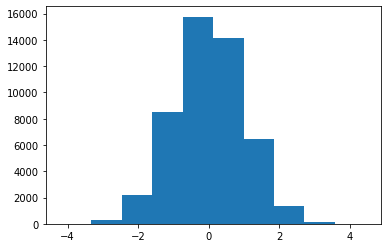

In [11]:
distri = np.random.randn(len(dataset))
plt.hist(distri)

In [12]:
# observamos la estructura del dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [53]:
class funciones:
   def __init__(self,dataset):
       self.data = dataset
   def graficaMapas(self,orden,columna,reg):
     data1 = self.data.sort_values(by=[columna],ascending=orden).head(reg)
     mapa = folium.Map([40.8,-73.8],zoom_start=11,tiles='openstreetmap')
     mapa_cluster = plugins.MarkerCluster().add_to(mapa)
     ##Agregamos los coordenadas al mapa para que se puedan visualizar
     for lati, longi, etiqueta in zip(data1.latitude,data1.longitude,data1.name):
           folium.Marker(location=[lati,longi],
                    icon=folium.Icon(icon='home'),
                    popup=etiqueta).add_to(mapa_cluster)
     return mapa.add_child(mapa_cluster)
   
   def calcula_estaditica(self,columna):
     print("  Media:", np.mean(self.data[columna]))
     print("  Maximo: ", np.max(self.data[columna]))
     print("  Minimo: ", np.min(self.data[columna]))
     print("  Rango: ", np.ptp(self.data[columna],axis=0))
     print("  Std   : ", np.std(self.data[columna]))
   
   def etiquetado(self,columna):
     etiquetado = preprocessing.LabelEncoder()
     etiquetado.fit(self.data[columna])
     out =  etiquetado.transform(self.data[columna]) 
     return out
   
   def datos_comparacion(self,ytest,y_pred):
     y_pre_manual_list = ytest.tolist()
     y_pred_sklean_list =y_pred.tolist()
     datos = pd.DataFrame(
             {
                 "y_test":y_pre_manual_list ,
                 "y_pred":y_pred_sklean_list
             }
         )
     return datos  
   
   def grafica_comparativa(self,ytest,y_pred):
     plt.subplot(1, 2, 2)
     plt.figure(figsize=(16, 8))
     sns.regplot(y_predict, ytest, scatter_kws={'alpha':0.3})
     plt.xlabel('Valores ajustados')
     plt.ylabel('Valores observados')
     plt.title("Predicciones del modelo de redes neuronales")
     plt.show()    

In [14]:
# instanceamos nuestra clase
funcion = funciones(dataset)

In [15]:
# Visualización de hospedaje por precion de mayor a menor
funcion.graficaMapas(False,'price',1000)

In [16]:
print(funcion.calcula_estaditica('price'))
print(funcion.calcula_estaditica('number_of_reviews'))
print(funcion.calcula_estaditica('reviews_per_month'))


  Media: 152.7206871868289
  Maximo:  10000
  Minimo:  0
  Rango:  10000
  Std   :  240.15171391941718
None
  Media: 23.274465691788528
  Maximo:  629
  Minimo:  0
  Rango:  629
  Std   :  44.55012669034631
None
  Media: 1.3732214298586618
  Maximo:  58.5
  Minimo:  0.01
  Rango:  nan
  Std   :  1.6804203639276272
None


**Correlacion entre variables**

In [17]:
correlacion = dataset.corr()

In [18]:
correlacion

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
id,1.000000,0.588290,-0.003125,0.090908,0.010619,-0.013224,-0.319760,0.291828,0.133272,0.085468
host_id,0.588290,1.000000,0.020224,0.127055,0.015309,-0.017364,-0.140106,0.296417,0.154950,0.203492
latitude,-0.003125,0.020224,1.000000,0.084788,0.033939,0.024869,-0.015389,-0.010142,0.019517,-0.010983
longitude,0.090908,0.127055,0.084788,1.000000,-0.150019,-0.062747,0.059094,0.145948,-0.114713,0.082731
price,0.010619,0.015309,0.033939,-0.150019,1.000000,0.042799,-0.047954,-0.030608,0.057472,0.081829
minimum_nights,-0.013224,-0.017364,0.024869,-0.062747,0.042799,1.000000,-0.080116,-0.121702,0.127960,0.144303
number_of_reviews,-0.319760,-0.140106,-0.015389,0.059094,-0.047954,-0.080116,1.000000,0.549868,-0.072376,0.172028
reviews_per_month,0.291828,0.296417,-0.010142,0.145948,-0.030608,-0.121702,0.549868,1.000000,-0.009421,0.185791
calculated_host_listings_count,0.133272,0.154950,0.019517,-0.114713,0.057472,0.127960,-0.072376,-0.009421,1.000000,0.225701
availability_365,0.085468,0.203492,-0.010983,0.082731,0.081829,0.144303,0.172028,0.185791,0.225701,1.000000


Procesamiento y preparación de datos para predicción

In [19]:
dataset1 = dataset.copy()

In [20]:
dataset1=dataset[dataset['price']<=1000].copy()
#dataset1=dataset.copy()
dataset1.drop(['name','id','host_name','host_id','last_review'], axis=1, inplace=True)
dataset1['reviews_per_month'] = dataset1['reviews_per_month'].replace(np.nan,0)

In [21]:
dataset1.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


#etiquetamos columnas categoricas que utilizaremos


In [22]:
funcion = funciones(dataset1)
dataset1['neighbourhood']=funcion.etiquetado('neighbourhood')

In [23]:
dataset1.head(5)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,108,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,127,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,94,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,41,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,61,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [24]:
dataset1['neighbourhood_group']=funcion.etiquetado('neighbourhood_group')
dataset1['room_type']=funcion.etiquetado('room_type')


In [25]:
dataset1.head(10)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,1,108,40.64749,-73.97237,1,149,1,9,0.21,6,365
1,2,127,40.75362,-73.98377,0,225,1,45,0.38,2,355
2,2,94,40.80902,-73.94190,1,150,3,0,0.00,1,365
3,1,41,40.68514,-73.95976,0,89,1,270,4.64,1,194
4,2,61,40.79851,-73.94399,0,80,10,9,0.10,1,0
5,2,137,40.74767,-73.97500,0,200,3,74,0.59,1,129
6,1,13,40.68688,-73.95596,1,60,45,49,0.40,1,0
7,2,95,40.76489,-73.98493,1,79,2,430,3.47,1,220
8,2,202,40.80178,-73.96723,1,79,2,118,0.99,1,0
9,2,35,40.71344,-73.99037,0,150,1,160,1.33,4,188


In [26]:
regressors = ['neighbourhood_group', 'latitude','longitude','room_type',
              'minimum_nights','number_of_reviews','reviews_per_month',
              'calculated_host_listings_count','availability_365']
X = dataset1[regressors]
y = dataset1['price']
#Z = dataset1[regressors]

In [27]:
valorEscalado = y.max()
y = y / y.max()


In [28]:
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
print(X.shape)

(48656, 9)


In [29]:
X

array([[-0.91586997, -1.49253402, -0.44025702, ..., -0.55310546,
        -0.03518473,  1.92161609],
       [ 0.44175156,  0.45239275, -0.6872023 , ..., -0.44681975,
        -0.15631385,  1.8455291 ],
       [ 0.44175156,  1.46764709,  0.21978004, ..., -0.68439958,
        -0.18659613,  1.92161609],
       ...,
       [ 0.44175156,  1.57265444,  0.07312921, ..., -0.68439958,
        -0.18659613, -0.65012422],
       [ 0.44175156,  0.52368047, -0.84641701, ..., -0.68439958,
        -0.03518473, -0.84034169],
       [ 0.44175156,  0.64334853, -0.80764227, ..., -0.68439958,
        -0.18659613, -0.68055901]])

Conjunto de entrenamiento y pruebas

In [30]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=101)

In [31]:
Xtrain.shape, Xtest.shape

((38924, 9), (9732, 9))


Modelo de perceptrones multicapa (MLP)



In [32]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [33]:
modelo = Sequential()
modelo.add(Dense(8,input_dim=Xtrain.shape[1],activation='relu'))
modelo.add(Dense(5,activation='relu'))
modelo.add(Dense(3,activation='relu'))
modelo.add(Dense(1,activation='linear'))


In [34]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 80        
                                                                 
 dense_1 (Dense)             (None, 5)                 45        
                                                                 
 dense_2 (Dense)             (None, 3)                 18        
                                                                 
 dense_3 (Dense)             (None, 1)                 4         
                                                                 
Total params: 147
Trainable params: 147
Non-trainable params: 0
_________________________________________________________________


In [35]:
loss = 'mea_squared_error'
optimizar='Nadam'
lr = 0.00001
validation_split = 0.2
batch_size = 1000
epoch=98


modelo.compile(loss='mean_squared_error',optimizer='adam')

checkpoint = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

history = modelo.fit(Xtrain, ytrain, 
                    epochs=epoch, validation_split=validation_split, 
                    batch_size=batch_size, verbose=1,
                    callbacks=[checkpoint])

Epoch 1/98
32/32 [==============================] - 1s 8ms/step - loss: 0.0247 - val_loss: 0.0196
Epoch 2/98
32/32 [==============================] - 0s 3ms/step - loss: 0.0168 - val_loss: 0.0155
Epoch 3/98
32/32 [==============================] - 0s 3ms/step - loss: 0.0138 - val_loss: 0.0135
Epoch 4/98
32/32 [==============================] - 0s 3ms/step - loss: 0.0122 - val_loss: 0.0124
Epoch 5/98
32/32 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0118
Epoch 6/98
32/32 [==============================] - 0s 2ms/step - loss: 0.0110 - val_loss: 0.0113
Epoch 7/98
32/32 [==============================] - 0s 3ms/step - loss: 0.0106 - val_loss: 0.0109
Epoch 8/98
32/32 [==============================] - 0s 3ms/step - loss: 0.0102 - val_loss: 0.0106
Epoch 9/98
32/32 [==============================] - 0s 3ms/step - loss: 0.0100 - val_loss: 0.0103
Epoch 10/98
32/32 [==============================] - 0s 2ms/step - loss: 0.0098 - val_loss: 0.0101
Epoch 11/98
32/32 [

In [51]:
y_predict = modelo.predict(Xtest)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



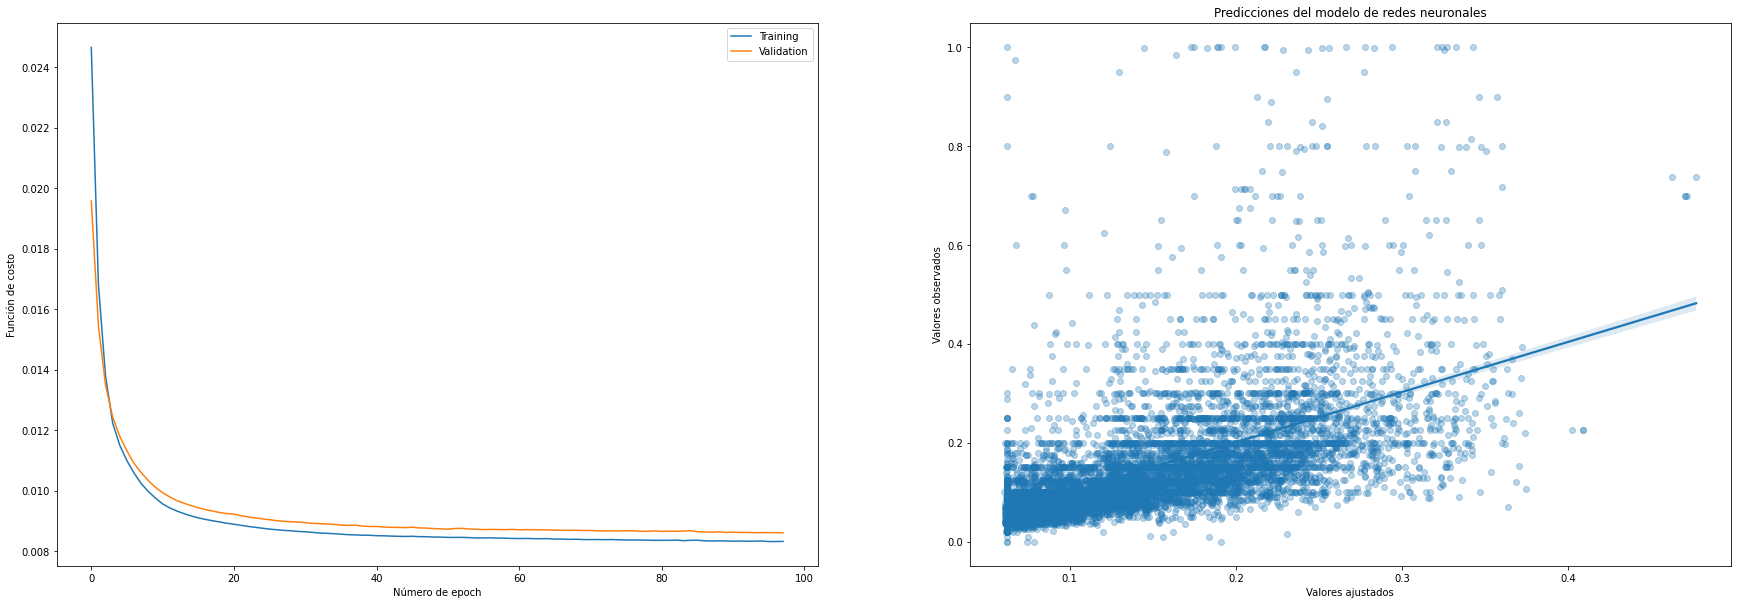

In [55]:
# Graficar la función de costo
plt.figure(figsize=(30,10))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Training")
plt.plot(history.history['val_loss'], label="Validation")
plt.xlabel("Número de epoch")
plt.ylabel("Función de costo")
plt.legend();

plt.subplot(1, 2, 2)
sns.regplot(y_predict, ytest, scatter_kws={'alpha':0.3})
plt.xlabel('Valores ajustados')
plt.ylabel('Valores observados')
plt.title("Predicciones del modelo de redes neuronales")
plt.show()  


In [ ]:
print("RMSE= %0.4f, R^2 = %0.2f" % (np.sqrt(metrics.mean_squared_error(ytest, y_predict)), 
                                   r2_score(ytest, y_predict)))

In [40]:
funcion = funciones(dataset1)

In [41]:
funcion.datos_comparacion(ytest,y_predict.flatten()) * valorEscalado

,y_test,y_pred
0,250.0,212.946907
1,139.0,193.451732
2,75.0,71.394853
3,1000.0,327.155232
4,275.0,216.471478
...,...,...
9727,170.0,118.071206
9728,100.0,71.979940
9729,170.0,197.906613
9730,172.0,190.456882


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



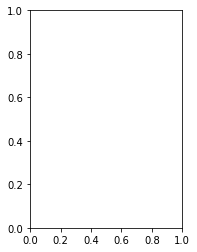

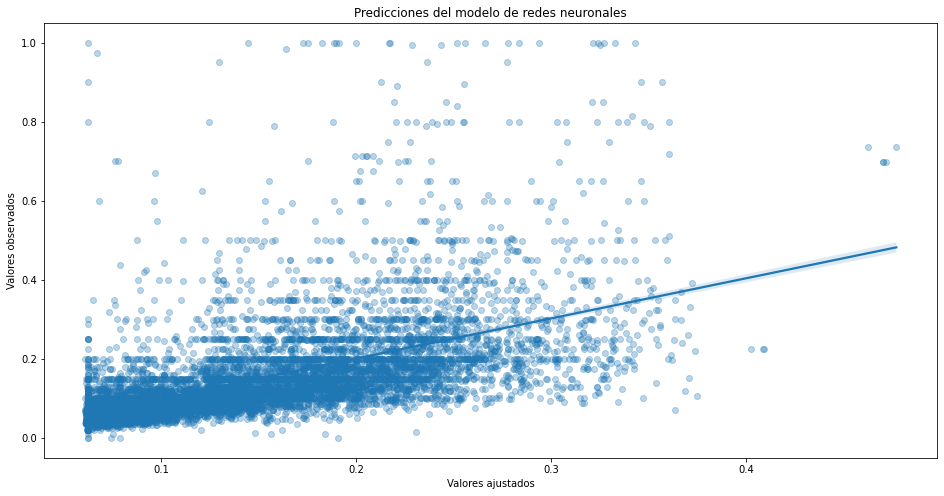

In [56]:
funcion.grafica_comparativa(ytest,y_predict)

Conclusiones

Este proyecto se pudo construir con un modelo lineal pero se utilizo un modelo perceptrones MLP.

El parametro que se tomo para la efectividad de prediccion de este modelo es R2 y el RSME, por lo que obtivimos parametros optimos para determinar que el modelo se puede utilizar, pero concluimos que este modelo se puede mejorar aplicando mas feature engineering lo cual se estare realizando para que el modelo sea más eficiente.